In [16]:
import pandas as pd
import os

# Step 1: Load and normalize data
def load_data(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            stock_name = file.split('.')[0]
            df = pd.read_csv(os.path.join(folder_path, file), parse_dates=['date'], index_col='date')
            data[stock_name] = df[['open', 'high', 'low', 'close', 'volume']]
    return data

def normalize_data(data):
    for stock, df in data.items():
        df['close'] = df['close'] / df['close'].iloc[0]  # Normalize based on the first close price
    return data

# Step 2: Feature extraction - Calculate support and resistance
def find_support_resistance(df, window):
    supports = df['low'].rolling(window=window).min()  # Minimum low in the window as support
    resistances = df['high'].rolling(window=window).max()  # Maximum high in the window as resistance
    return supports, resistances

# Step 3: Save support and resistance levels to a CSV
def save_support_resistance(data, output_file, short_window=60, long_window=180):
    support_resistance_data = []

    for stock, df in data.items():
        df['Short_Support'], df['Short_Resistance'] = find_support_resistance(df, short_window)
        df['Long_Support'], df['Long_Resistance'] = find_support_resistance(df, long_window)
        
        # Save relevant details for each support/resistance level
        for date, row in df.iterrows():
            support_resistance_data.append({
                'Stock': stock,
                'date': date,
                'Short_Support': row['Short_Support'],
                'Short_Resistance': row['Short_Resistance'],
                'Long_Support': row['Long_Support'],
                'Long_Resistance': row['Long_Resistance']
            })
    
    # Create a DataFrame and save it to a CSV file
    support_resistance_df = pd.DataFrame(support_resistance_data)
    support_resistance_df.to_csv(output_file, index=False)
    print(f"Support and resistance levels saved to {output_file}")

# Main execution
data = load_data('best_performing_stocks')  # Replace with your folder path
normalized_data = normalize_data(data)

# Save support and resistance levels with short and long windows
save_support_resistance(normalized_data, 'support_resistance_levels.csv', short_window=60, long_window=180)


Support and resistance levels saved to support_resistance_levels.csv


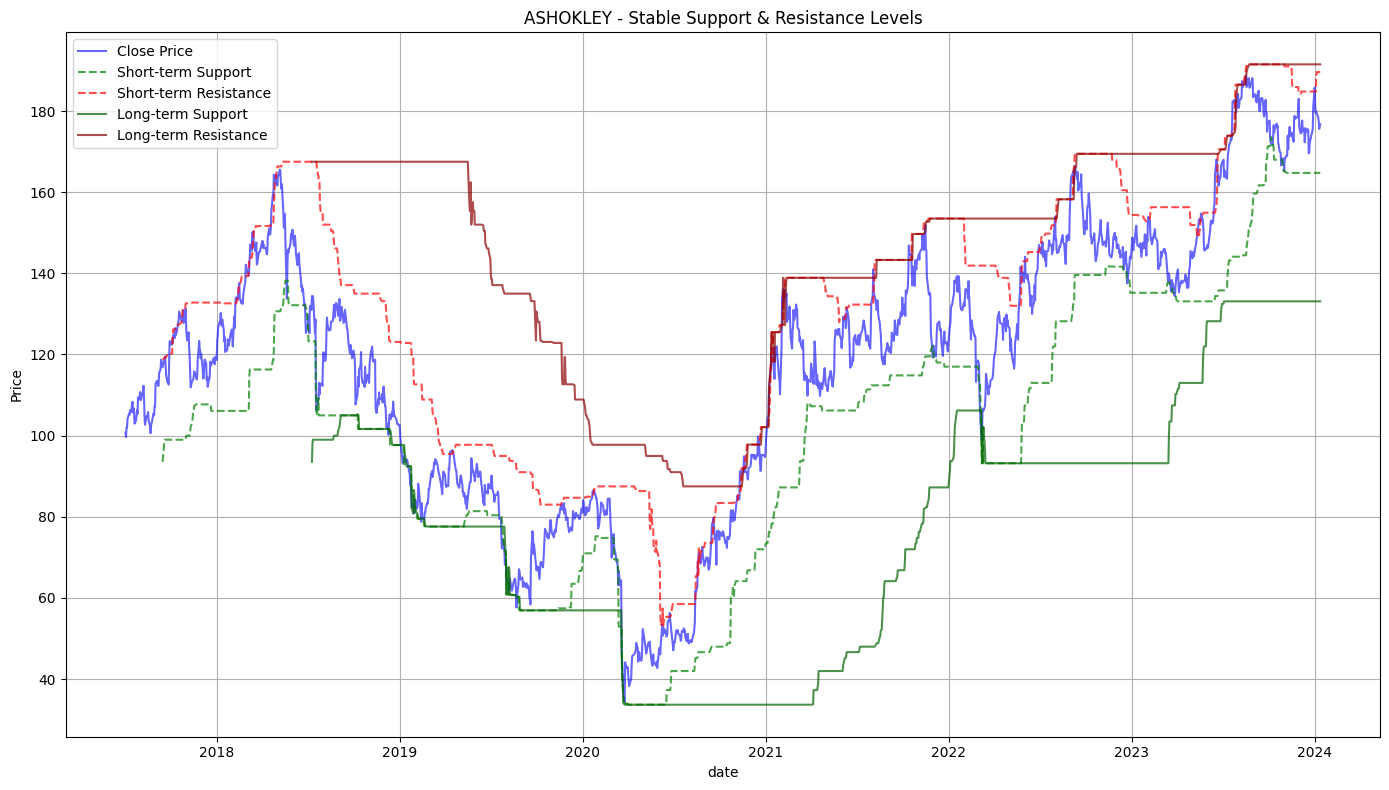

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Step 1: Load data
def load_data(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            stock_name = file.split('.')[0]
            df = pd.read_csv(os.path.join(folder_path, file), parse_dates=['date'], index_col='date')
            data[stock_name] = df[['open', 'high', 'low', 'close', 'volume']]
    return data

# Step 2: Calculate stable support and resistance levels
def find_stable_support_resistance(df, short_window, long_window, tolerance=0.01):
    # Pivot points based on typical price
    df['Pivot'] =  df['close']
    
    # Calculate initial supports and resistances
    short_support = df['low'].rolling(window=short_window).min()
    short_resistance = df['high'].rolling(window=short_window).max()
    long_support = df['low'].rolling(window=long_window).min()
    long_resistance = df['high'].rolling(window=long_window).max()

    # Adjust levels to be more stable using a tolerance threshold
    df['Short_Support'] = short_support
    df['Short_Resistance'] = short_resistance
    df['Long_Support'] = long_support
    df['Long_Resistance'] = long_resistance

    # Smooth the changes to make levels more stable
    df['Short_Support'] = df['Short_Support'].where(
        (df['Short_Support'] - df['Short_Support'].shift(3)).abs() > tolerance * df['close'].shift(3),
        df['Short_Support'].shift(3)
    )
    df['Short_Resistance'] = df['Short_Resistance'].where(
        (df['Short_Resistance'] - df['Short_Resistance'].shift(3)).abs() > tolerance * df['close'].shift(3),
        df['Short_Resistance'].shift(3)
    )
    df['Long_Support'] = df['Long_Support'].where(
        (df['Long_Support'] - df['Long_Support'].shift(5)).abs() > tolerance * df['close'].shift(5),
        df['Long_Support'].shift(5)
    )
    df['Long_Resistance'] = df['Long_Resistance'].where(
        (df['Long_Resistance'] - df['Long_Resistance'].shift(5)).abs() > tolerance * df['close'].shift(5),
        df['Long_Resistance'].shift(5)
    )
    
    return df

# Step 3: Plot stock prices with stable support and resistance
def plot_support_resistance(df, stock_name):
    plt.figure(figsize=(14, 8))
    plt.plot(df.index, df['close'], label='Close Price', color='blue', alpha=0.6)
    plt.plot(df.index, df['Short_Support'], label='Short-term Support', color='green', linestyle='--', alpha=0.7)
    plt.plot(df.index, df['Short_Resistance'], label='Short-term Resistance', color='red', linestyle='--', alpha=0.7)
    plt.plot(df.index, df['Long_Support'], label='Long-term Support', color='darkgreen', linestyle='-', alpha=0.7)
    plt.plot(df.index, df['Long_Resistance'], label='Long-term Resistance', color='darkred', linestyle='-', alpha=0.7)
    
    plt.title(f"{stock_name} - Stable Support & Resistance Levels")
    plt.xlabel('date')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
data = load_data('best_performing_stocks')  # Replace with your folder path

# Select a specific stock to visualize (e.g., 'AAPL')
stock_name = 'ASHOKLEY'
if stock_name in data:
    df = data[stock_name]
    df = find_stable_support_resistance(df, short_window=50, long_window=250, tolerance=0.1)  # Adjust tolerance as needed
    plot_support_resistance(df, stock_name)
else:
    print(f"Stock {stock_name} not found in the dataset.")